<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/07_Otros/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch-tabnet

In [73]:
% load_ext autoreload
% autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def plotBoundaryDT(data, labels, X_test,y_test, clf_1=None, N=20):
    class_1 = data[labels == 1]
    class_0 = data[labels == 0]
    mins = data[:,:2].min(axis=0)
    maxs = data[:,:2].max(axis=0)
    x1 = np.linspace(mins[0], maxs[0], N)
    x2 = np.linspace(mins[1], maxs[1], N)
    x1, x2 = np.meshgrid(x1, x2)
    X=np.c_[x1.flatten(), x2.flatten()]
    fig = plt.figure(figsize=(18,6))
    plt.subplot(121)
    ax = fig.gca()
    cm = plt.cm.RdBu
    if(clf_1):
        Z_nn = clf_1.predict_proba(X)[:, 0]
        # Put the result into a color plot
        Z_nn = Z_nn.reshape(x1.shape)
        ax.contourf(x1, x2, Z_nn,cmap=plt.cm.RdYlBu)
    #ax.scatter(class_1[:,0], class_1[:,1], color='r', s=20, alpha=0.5)
    #ax.scatter(class_0[:,0], class_0[:,1], color='b', s=20, alpha=0.5)
    class_1 = X_test[y_test == 1]
    class_0 = X_test[y_test == 0]
    plt.subplot(122)
    ax = fig.gca()
    cm = plt.cm.RdBu
    if(clf_1):
        Z_nn = clf_1.predict_proba(X)[:, 0]
        # Put the result into a color plot
        Z_nn = Z_nn.reshape(x1.shape)
        ax.contourf(x1, x2, Z_nn,cmap=plt.cm.RdYlBu)
    ax.scatter(class_1[:,0], class_1[:,1], color='r', s=20, alpha=0.5)
    ax.scatter(class_0[:,0], class_0[:,1], color='b', s=20, alpha=0.5)

In [6]:
def generate_gaussians(N0,N1,mu0,mu1,s):
    # N1: Cantidad de personas
    sigma=[[s,0],[0,s]]
    np.random.seed(231)
    X=np.vstack([np.random.multivariate_normal(mu0, sigma,N0),np.random.multivariate_normal(mu1, sigma,N1)])
    y=np.hstack([np.zeros(N0),np.ones(N1)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
    return X_train, X_test, y_train, y_test

In [85]:
def gen_TabNetClassifier(X_train, y_train, X_test, y_test):
    tabnet_params = {"cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

    clf = TabNetClassifier(**tabnet_params)
    
    max_epochs = 100
                     
    clf.fit(
        X_train=X_train, y_train=y_train,        
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    
    preds = clf.predict_proba(X_train)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_train)

    print("Train Score: {}".format(test_auc))

    preds = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)   
    
    print("Test Score: {}".format(test_auc))
    
    plotBoundaryDT(X_train,y_train,X_test,y_test,clf,N=500)

In [86]:
X_train, X_test, y_train, y_test=generate_gaussians(N0=1000,N1=1000,mu0=[2,5],mu1=[3,3],s=2)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.74567 |  0:00:00s
epoch 1  | loss: 0.51681 |  0:00:00s
epoch 2  | loss: 0.47274 |  0:00:00s
epoch 3  | loss: 0.48352 |  0:00:00s
epoch 4  | loss: 0.50947 |  0:00:00s
epoch 5  | loss: 0.49399 |  0:00:00s
epoch 6  | loss: 0.47027 |  0:00:00s
epoch 7  | loss: 0.46852 |  0:00:00s
epoch 8  | loss: 0.47996 |  0:00:00s
epoch 9  | loss: 0.46501 |  0:00:00s
epoch 10 | loss: 0.49343 |  0:00:00s
epoch 11 | loss: 0.44541 |  0:00:00s
epoch 12 | loss: 0.46251 |  0:00:00s
epoch 13 | loss: 0.47013 |  0:00:00s
epoch 14 | loss: 0.45458 |  0:00:00s
epoch 15 | loss: 0.45449 |  0:00:00s
epoch 16 | loss: 0.4528  |  0:00:00s
epoch 17 | loss: 0.4599  |  0:00:01s
epoch 18 | loss: 0.45718 |  0:00:01s
epoch 19 | loss: 0.4749  |  0:00:01s
epoch 20 | loss: 0.45457 |  0:00:01s
epoch 21 | loss: 0.44275 |  0:00:01s
epoch 22 | loss: 0.4186  |  0:00:01s
epoch 23 | loss: 0.4367  |  0:00:01s
epoch 24 | loss: 0.44

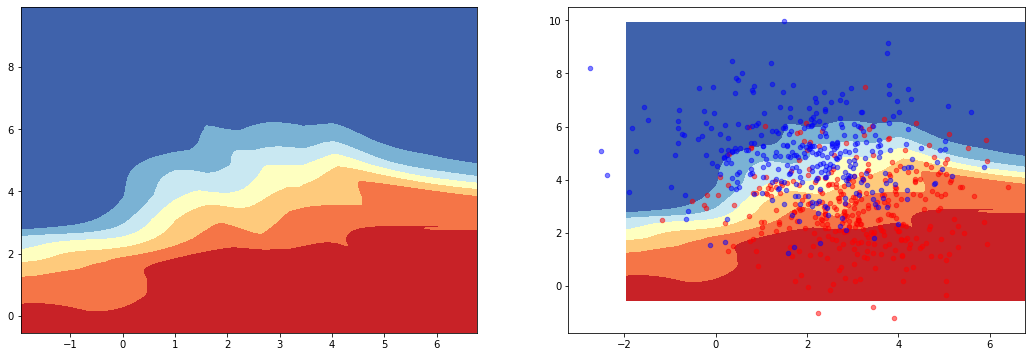

In [87]:
gen_TabNetClassifier(X_train, y_train, X_test, y_test)